In [1]:
try:
    import openmdao.api as om
    import dymos as dm
except ImportError:
    !python -m pip install openmdao[notebooks]
    !python -m pip install dymos
    import openmdao.api as om
    import dymos as dm

# Multibranch Trajectory

This example demonstrates the use of a Trajectory to encapsulate a
series of branching phases.

## Overview

For this example, we build a system that contains two components: the
first component represents a battery pack that contains multiple cells
in parallel, and the second component represents a bank of DC electric
motors (also in parallel) driving a gearbox to achieve a desired power
output. The battery cells have a state of charge that decays as current
is drawn from the battery. The open circuit voltage of the battery is a
function of the state of charge. At any point in time, the coupling
between the battery and the motor component is solved with a Newton
solver in the containing group for a line current that satisfies the
equations.

Both the battery and the motor models allow the number of cells and the
number of motors to be modified by setting the _n\_parallel_ option in
their respective options dictionaries. For this model, we start with 3
cells and 3 motors. We will simulate failure of a cell or battery by
setting _n\_parallel_ to 2.

Branching phases are a set of linked phases in a trajectory where the
input ends of multiple phases are connected to the output of a single
phase. This way you can simulate alternative trajectory paths in the
same model. For this example, we will start with a single phase
(_phase0_) that simulates the model for one hour. Three follow-on
phases will be linked to the output of the first phase: _phase1_ will
run as normal, _phase1\_bfail_ will fail one of the battery cells, and
_phase1\_mfail_ will fail a motor. All three of these phases start
where _phase0_ leaves off, so they share the same initial time and
state of charge.

## Battery and Motor models

The models are loosely based on the work done in Chin {cite}`chin2019battery`.

In [2]:
"""
Simple dynamic model of a LI battery.
"""
import numpy as np
from scipy.interpolate import Akima1DInterpolator

import openmdao.api as om
# Data for open circuit voltage model.
train_SOC = np.array([0., 0.1, 0.25, 0.5, 0.75, 0.9, 1.0])
train_V_oc = np.array([3.5, 3.55, 3.65, 3.75, 3.9, 4.1, 4.2])


class Battery(om.ExplicitComponent):
    """
    Model of a Lithium Ion battery.
    """

    def initialize(self):
        self.options.declare('num_nodes', default=1)
        self.options.declare('n_series', default=1, desc='number of cells in series')
        self.options.declare('n_parallel', default=3, desc='number of cells in parallel')
        self.options.declare('Q_max', default=1.05,
                             desc='Max Energy Capacity of a battery cell in A*h')
        self.options.declare('R_0', default=.025,
                             desc='Internal resistance of the battery (ohms)')

    def setup(self):
        num_nodes = self.options['num_nodes']

        # Inputs
        self.add_input('I_Li', val=np.ones(num_nodes), units='A',
                       desc='Current demanded per cell')

        # State Variables
        self.add_input('SOC', val=np.ones(num_nodes), units=None, desc='State of charge')

        # Outputs
        self.add_output('V_L',
                        val=np.ones(num_nodes),
                        units='V',
                        desc='Terminal voltage of the battery')

        self.add_output('dXdt:SOC',
                        val=np.ones(num_nodes),
                        units='1/s',
                        desc='Time derivative of state of charge')

        self.add_output('V_oc', val=np.ones(num_nodes), units='V',
                        desc='Open Circuit Voltage')
        self.add_output('I_pack', val=0.1*np.ones(num_nodes), units='A',
                        desc='Total Pack Current')
        self.add_output('V_pack', val=9.0*np.ones(num_nodes), units='V',
                        desc='Total Pack Voltage')
        self.add_output('P_pack', val=1.0*np.ones(num_nodes), units='W',
                        desc='Total Pack Power')

        # Derivatives
        row_col = np.arange(num_nodes)

        self.declare_partials(of='V_oc', wrt=['SOC'], rows=row_col, cols=row_col)
        self.declare_partials(of='V_L', wrt=['SOC'], rows=row_col, cols=row_col)
        self.declare_partials(of='V_L', wrt=['I_Li'], rows=row_col, cols=row_col)
        self.declare_partials(of='dXdt:SOC', wrt=['I_Li'], rows=row_col, cols=row_col)
        self.declare_partials(of='I_pack', wrt=['I_Li'], rows=row_col, cols=row_col)
        self.declare_partials(of='V_pack', wrt=['SOC', 'I_Li'], rows=row_col, cols=row_col)
        self.declare_partials(of='P_pack', wrt=['SOC', 'I_Li'], rows=row_col, cols=row_col)

        self.voltage_model = Akima1DInterpolator(train_SOC, train_V_oc)
        self.voltage_model_derivative = self.voltage_model.derivative()

    def compute(self, inputs, outputs):
        opt = self.options
        I_Li = inputs['I_Li']
        SOC = inputs['SOC']

        V_oc = self.voltage_model(SOC, extrapolate=True)

        outputs['V_oc'] = V_oc
        outputs['V_L'] = V_oc - (I_Li * opt['R_0'])
        outputs['dXdt:SOC'] = -I_Li / (3600.0 * opt['Q_max'])

        outputs['I_pack'] = I_Li * opt['n_parallel']
        outputs['V_pack'] = outputs['V_L'] * opt['n_series']
        outputs['P_pack'] = outputs['I_pack'] * outputs['V_pack']

    def compute_partials(self, inputs, partials):
        opt = self.options
        I_Li = inputs['I_Li']
        SOC = inputs['SOC']

        dV_dSOC = self.voltage_model_derivative(SOC, extrapolate=True)
        partials['V_oc', 'SOC'] = dV_dSOC
        partials['V_L', 'SOC'] = dV_dSOC

        partials['V_L', 'I_Li'] = -opt['R_0']

        partials['dXdt:SOC', 'I_Li'] = -1./(3600.0*opt['Q_max'])

        n_parallel = opt['n_parallel']
        n_series = opt['n_series']
        V_oc = self.voltage_model(SOC, extrapolate=True)
        V_L = V_oc - (I_Li * opt['R_0'])

        partials['I_pack', 'I_Li'] = n_parallel
        partials['V_pack', 'I_Li'] = -opt['R_0']
        partials['V_pack', 'SOC'] = n_series * dV_dSOC
        partials['P_pack', 'I_Li'] = n_parallel * n_series * (V_L - I_Li * opt['R_0'])
        partials['P_pack', 'SOC'] = n_parallel * I_Li * n_series * dV_dSOC


# num_nodes = 1

# prob = om.Problem(model=Battery(num_nodes=num_nodes))
# model = prob.model

# prob.setup()
# prob.set_solver_print(level=2)

# prob.run_model()

# derivs = prob.check_partials(compact_print=True)

In [3]:
"""
Simple model for a set of motors in parallel where efficiency is a function of current.
"""
import numpy as np

import openmdao.api as om


class Motors(om.ExplicitComponent):
    """
    Model for motors in parallel.
    """

    def initialize(self):
        self.options.declare('num_nodes', default=1)
        self.options.declare('n_parallel', default=3, desc='number of motors in parallel')

    def setup(self):
        num_nodes = self.options['num_nodes']

        # Inputs
        self.add_input('power_out_gearbox', val=3.6*np.ones(num_nodes), units='W',
                       desc='Power at gearbox output')
        self.add_input('current_in_motor', val=np.ones(num_nodes), units='A',
                       desc='Total current demanded')

        # Outputs
        self.add_output('power_in_motor', val=np.ones(num_nodes), units='W',
                        desc='Power required at motor input')

        # Derivatives
        row_col = np.arange(num_nodes)

        self.declare_partials(of='power_in_motor', wrt=['*'], rows=row_col, cols=row_col)

    def compute(self, inputs, outputs):
        current = inputs['current_in_motor']
        power_out = inputs['power_out_gearbox']
        n_parallel = self.options['n_parallel']

        # Simple linear curve fit for efficiency.
        eff = 0.9 - 0.3 * current / n_parallel

        outputs['power_in_motor'] = power_out / eff

    def compute_partials(self, inputs, partials):
        current = inputs['current_in_motor']
        power_out = inputs['power_out_gearbox']
        n_parallel = self.options['n_parallel']

        eff = 0.9 - 0.3 * current / n_parallel

        partials['power_in_motor', 'power_out_gearbox'] = 1.0 / eff
        partials['power_in_motor', 'current_in_motor'] = 0.3 * power_out / (n_parallel * eff**2)


# num_nodes = 1

# prob = om.Problem(model=Motors(num_nodes=num_nodes))
# model = prob.model

# prob.setup()

# prob.run_model()

# derivs = prob.check_partials(compact_print=True)

In [4]:
"""
ODE for example that shows how to use multiple phases in Dymos to model failure of a battery cell
in a simple electrical system.
"""
import numpy as np
import openmdao.api as om

from dymos.examples.battery_multibranch.batteries import Battery
from dymos.examples.battery_multibranch.motors import Motors


class BatteryODE(om.Group):

    def initialize(self):
        self.options.declare('num_nodes', default=1)
        self.options.declare('num_battery', default=3)
        self.options.declare('num_motor', default=3)

    def setup(self):
        num_nodes = self.options['num_nodes']
        num_battery = self.options['num_battery']
        num_motor = self.options['num_motor']

        self.add_subsystem(name='pwr_balance',
                           subsys=om.BalanceComp(name='I_Li', val=1.0*np.ones(num_nodes),
                                                 rhs_name='pwr_out_batt',
                                                 lhs_name='P_pack',
                                                 units='A', eq_units='W', lower=0.0, upper=50.))

        self.add_subsystem('battery', Battery(num_nodes=num_nodes, n_parallel=num_battery),
                           promotes_inputs=['SOC'],
                           promotes_outputs=['dXdt:SOC'])

        self.add_subsystem('motors', Motors(num_nodes=num_nodes, n_parallel=num_motor))

        self.connect('battery.P_pack', 'pwr_balance.P_pack')
        self.connect('motors.power_in_motor', 'pwr_balance.pwr_out_batt')
        self.connect('pwr_balance.I_Li', 'battery.I_Li')
        self.connect('battery.I_pack', 'motors.current_in_motor')

        self.nonlinear_solver = om.NewtonSolver(solve_subsystems=False, maxiter=20)
        self.linear_solver = om.DirectSolver()


## Building and running the problem

--- Linkage Report [traj] ---
    --- phase0 - phase1 ---
        state_of_charge [final]  ==  state_of_charge [initial]
        time            [final]  ==  time            [initial]
----------------------------
    --- phase0 - phase1_bfail ---
        state_of_charge [final]  ==  state_of_charge [initial]
        time            [final]  ==  time            [initial]
----------------------------
    --- phase0 - phase1_mfail ---
        state_of_charge [final]  ==  state_of_charge [initial]
        time            [final]  ==  time            [initial]
----------------------------
Full total jacobian was computed 3 times, taking 0.107224 seconds.
Total jacobian shape: (107, 122) 


Jacobian shape: (107, 122)  ( 4.63% nonzero)
FWD solves: 6   REV solves: 0
Total colors vs. total size: 6 vs 122  (95.1% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.107224 sec.
Time to compute coloring: 0.089119 sec.
Memory to compute coloring: 0.199219 MB.
Optimizat

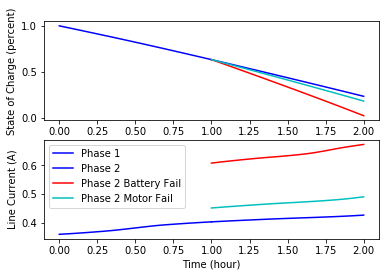

In [5]:
import matplotlib.pyplot as plt

import openmdao.api as om

import dymos as dm
from dymos.examples.battery_multibranch.battery_multibranch_ode import BatteryODE
from dymos.utils.lgl import lgl

prob = om.Problem()

opt = prob.driver = om.ScipyOptimizeDriver()
opt.declare_coloring()
opt.options['optimizer'] = 'SLSQP'

num_seg = 5
seg_ends, _ = lgl(num_seg + 1)

traj = prob.model.add_subsystem('traj', dm.Trajectory())

# First phase: normal operation.
transcription = dm.Radau(num_segments=num_seg, order=5, segment_ends=seg_ends, compressed=False)
phase0 = dm.Phase(ode_class=BatteryODE, transcription=transcription)
traj_p0 = traj.add_phase('phase0', phase0)

traj_p0.set_time_options(fix_initial=True, fix_duration=True)
traj_p0.add_state('state_of_charge', fix_initial=True, fix_final=False,
                  targets=['SOC'], rate_source='dXdt:SOC')

# Second phase: normal operation.

phase1 = dm.Phase(ode_class=BatteryODE, transcription=transcription)
traj_p1 = traj.add_phase('phase1', phase1)

traj_p1.set_time_options(fix_initial=False, fix_duration=True)
traj_p1.add_state('state_of_charge', fix_initial=False, fix_final=False,
                  targets=['SOC'], rate_source='dXdt:SOC')
traj_p1.add_objective('time', loc='final')

# Second phase, but with battery failure.

phase1_bfail = dm.Phase(ode_class=BatteryODE, ode_init_kwargs={'num_battery': 2},
                        transcription=transcription)
traj_p1_bfail = traj.add_phase('phase1_bfail', phase1_bfail)

traj_p1_bfail.set_time_options(fix_initial=False, fix_duration=True)
traj_p1_bfail.add_state('state_of_charge', fix_initial=False, fix_final=False,
                        targets=['SOC'], rate_source='dXdt:SOC')

# Second phase, but with motor failure.

phase1_mfail = dm.Phase(ode_class=BatteryODE, ode_init_kwargs={'num_motor': 2},
                        transcription=transcription)
traj_p1_mfail = traj.add_phase('phase1_mfail', phase1_mfail)

traj_p1_mfail.set_time_options(fix_initial=False, fix_duration=True)
traj_p1_mfail.add_state('state_of_charge', fix_initial=False, fix_final=False,
                        targets=['SOC'], rate_source='dXdt:SOC')

traj.link_phases(phases=['phase0', 'phase1'], vars=['state_of_charge', 'time'])
traj.link_phases(phases=['phase0', 'phase1_bfail'], vars=['state_of_charge', 'time'])
traj.link_phases(phases=['phase0', 'phase1_mfail'], vars=['state_of_charge', 'time'])

prob.model.options['assembled_jac_type'] = 'csc'
prob.model.linear_solver = om.DirectSolver(assemble_jac=True)

prob.setup()

prob['traj.phase0.t_initial'] = 0
prob['traj.phase0.t_duration'] = 1.0*3600

prob['traj.phase1.t_initial'] = 1.0*3600
prob['traj.phase1.t_duration'] = 1.0*3600

prob['traj.phase1_bfail.t_initial'] = 1.0*3600
prob['traj.phase1_bfail.t_duration'] = 1.0*3600

prob['traj.phase1_mfail.t_initial'] = 1.0*3600
prob['traj.phase1_mfail.t_duration'] = 1.0*3600

prob.set_solver_print(level=0)
dm.run_problem(prob)

soc0 = prob['traj.phase0.states:state_of_charge']
soc1 = prob['traj.phase1.states:state_of_charge']
soc1b = prob['traj.phase1_bfail.states:state_of_charge']
soc1m = prob['traj.phase1_mfail.states:state_of_charge']

# Plot Results
t0 = prob['traj.phases.phase0.time.time']/3600
t1 = prob['traj.phases.phase1.time.time']/3600
t1b = prob['traj.phases.phase1_bfail.time.time']/3600
t1m = prob['traj.phases.phase1_mfail.time.time']/3600

plt.subplot(2, 1, 1)
plt.plot(t0, soc0, 'b')
plt.plot(t1, soc1, 'b')
plt.plot(t1b, soc1b, 'r')
plt.plot(t1m, soc1m, 'c')
plt.xlabel('Time (hour)')
plt.ylabel('State of Charge (percent)')

I_Li0 = prob['traj.phases.phase0.rhs_all.pwr_balance.I_Li']
I_Li1 = prob['traj.phases.phase1.rhs_all.pwr_balance.I_Li']
I_Li1b = prob['traj.phases.phase1_bfail.rhs_all.pwr_balance.I_Li']
I_Li1m = prob['traj.phases.phase1_mfail.rhs_all.pwr_balance.I_Li']

plt.subplot(2, 1, 2)
plt.plot(t0, I_Li0, 'b')
plt.plot(t1, I_Li1, 'b')
plt.plot(t1b, I_Li1b, 'r')
plt.plot(t1m, I_Li1m, 'c')
plt.xlabel('Time (hour)')
plt.ylabel('Line Current (A)')

plt.legend(['Phase 1', 'Phase 2', 'Phase 2 Battery Fail', 'Phase 2 Motor Fail'], loc=2)

plt.show()

In [6]:
from openmdao.utils.assert_utils import assert_near_equal

# Final value for State of Chrage in each segment should be a good test.
print('State of Charge after 1 hour')
assert_near_equal(soc0[-1], 0.63464982, 1e-6)
print('State of Charge after 2 hours')
assert_near_equal(soc1[-1], 0.23794217, 1e-6)
print('State of Charge after 2 hours, battery fails at 1 hour')
assert_near_equal(soc1b[-1], 0.0281523, 1e-6)
print('State of Charge after 2 hours, motor fails at 1 hour')
assert_near_equal(soc1m[-1], 0.18625395, 1e-6)

State of Charge after 1 hour
State of Charge after 2 hours
State of Charge after 2 hours, battery fails at 1 hour
State of Charge after 2 hours, motor fails at 1 hour


2.624294655825915e-08

## References

```{bibliography}
:filter: docname in docnames
```